# Gene perturbation pipeline to predict the effect of treatment on specific cell types

## Description

This notebook covers  functions to analyze data from single cell gene perturbation experiments (e.g. CRISPR-Cas9) to predict the effect of a treatment on specific cell types using variational autoencoders (VAE) [scGen](https://github.com/theislab/scgen) applied to Kang 2018 [Kang et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29227470/). In particular, we exclude CD4+ T cells treated with IFN-beta treatment from the VAE training step and then predicted using the VAE model.

In [1]:
import warnings
import os
import pertpy as pt ## Tested v1.0.0
import scanpy as sc
import pandas as pd
from matplotlib import rcParams

### Note: using numpy<2.0 to avoid version issues

warnings.filterwarnings("ignore")

/Users/jdime/venv_bioinfo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Predict response of CD4+ T cells to IFN-beta treatment

Here scGen will estimate a difference vector between control and IFN-beta treated cells and add that vector to a populations of control CD4+ cells excluded in the training step to simulate their transcriptional response. The dataset comes from [Kang et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29227470/), which is a 10x scRNA-seq PBMC dataset from Lupus patients before and after 6h-treatment with INF-beta (8 patients, 16 samples, 8 cell types).

#### Load and massage Kang AnnData

In [4]:
adata = pt.dt.kang_2018()

### Rename conditions to compare
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

### Reformat metadata provided by Heumos et al
adata.obs['cluster'] = "c_" + adata.obs['cluster'].astype('str')
adata.obs['seurat_clusters'] = "c_" + adata.obs['seurat_clusters'].astype('str')
cluster_v_celltype  = pd.crosstab(adata.obs['cluster'], adata.obs['cell_type'])
seurat_v_celltype   = pd.crosstab(adata.obs['seurat_clusters'], adata.obs['cell_type'])

print(adata, adata.obs.cell_type.value_counts(), adata.obs.condition.value_counts(), sep = '\n\n')

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

cell_type
CD4 T cells          11238
CD14+ Monocytes       5697
B cells               2651
NK cells              1716
CD8 T cells           1621
FCGR3A+ Monocytes     1089
Dendritic cells        529
Megakaryocytes         132
Name: count, dtype: int64

condition
stimulated    12358
control       12315
Name: count, dtype: int64


### Setting up the Kang dataset for scGen

Using scanpy's notmalization and highly variable gene selection

In [6]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

We remove all CD4T cells from the training data (`adata_t`) to simulate a real-world scenario of not capturing a specific population during an experiment.

In [20]:
adata_no_t_stim = adata[~((adata.obs["cell_type"] == "CD4 T cells")
                  & (adata.obs["condition"] == "stimulated")
                 )].copy()

adata_only_t_stim = adata[((adata.obs["cell_type"] == "CD4 T cells")
                           & (adata.obs["condition"] == "stimulated")
                          )].copy()

print(adata_no_t_stim.obs[['cell_type','condition']].value_counts().sort_index(), 
      adata_only_t_stim.obs[['cell_type','condition']].value_counts().sort_index(), 
      sep='\n\n')

cell_type          condition 
CD4 T cells        control       5560
CD14+ Monocytes    control       2932
                   stimulated    2765
B cells            control       1316
                   stimulated    1335
NK cells           control        855
                   stimulated     861
CD8 T cells        control        811
                   stimulated     810
FCGR3A+ Monocytes  control        520
                   stimulated     569
Dendritic cells    control        258
                   stimulated     271
Megakaryocytes     control         63
                   stimulated      69
Name: count, dtype: int64

cell_type    condition 
CD4 T cells  stimulated    5678
Name: count, dtype: int64


In [22]:
pt.tl.Scgen.setup_anndata(adata_no_t_stim, batch_key="condition", labels_key="cell_type")

### Model construction and training

Using parameters suggested by [Heumos et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37002403/)

In [23]:
model = pt.tl.Scgen(adata_no_t_stim, n_hidden=800, n_latent=100, n_layers=2)

In [24]:
model.train(
    max_epochs=100, batch_size=32, early_stopping=True, early_stopping_patience=25
)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 27/100:  27%|███████                   | 27/100 [34:43<1:33:53, 77.18s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=4.41e+3]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 485.983. Signaling Trainer to stop.


In [27]:
adata_no_t_stim.obsm["scgen"] = model.get_latent_representation()

In [28]:
sc.pp.neighbors(adata_no_t_stim, use_rep="scgen")
sc.tl.umap(adata_no_t_stim)

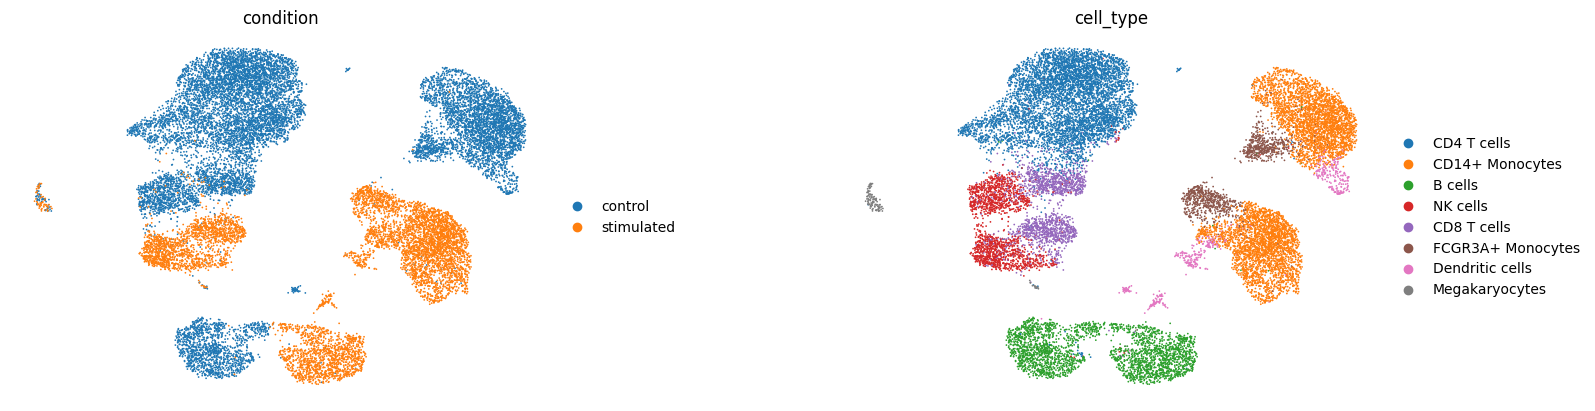

In [30]:
sc.pl.umap(adata_no_t_stim, color=["condition", "cell_type"], wspace=0.4, frameon=False)

The IFN-beta stimulation induced strong transcriptional changes across all cell-types, and conditions form groups of cells clearly distinguishable from each other.

### Predict response of CD4+ T cells to IFN-beta treatment

In [31]:
pred, delta = model.predict(
    ctrl_key="control", stim_key="stimulated", celltype_to_predict="CD4 T cells"
)

# re-annotate predicted cells to distinguish them later from ground truth cells.
pred.obs["condition"] = "predicted stimulated"

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


### Evaluating the predicted IFN-beta response

In [33]:
ctrl_adata = adata[
    ((adata.obs["cell_type"] == "CD4 T cells") & (adata.obs["condition"] == "control"))
]
# concatenate pred, control and real CD4 T cells in to one object
eval_adata = ctrl_adata.concatenate(adata_only_t_stim, pred)

In [34]:
eval_adata.obs.condition.value_counts()

condition
stimulated              5678
control                 5560
predicted stimulated    5560
Name: count, dtype: int64

We first look at the PCA co-embedding of control, IFN-beta stimulated and predicted CD4T cells.

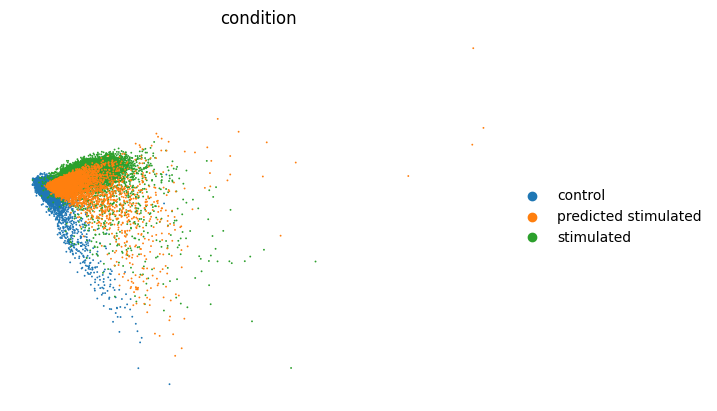

In [35]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False)

As observed above, the predicted stimulated cells were moved towards the CD4+ T cells stimulated with IFN-beta. Yet we should also look at differentially expressed genes (DEGs) to verify whether the most striking DE genes are also present in the predicted stimulated cells. Below, we look at the overall mean correlation between predicted and real cells. Before that, we extract DEGs between control and stimulated cells:

In [36]:
cd4t_adata = adata[adata.obs["cell_type"] == "CD4 T cells"]

We estimate DEGs using scanpy's implementation of the Wilcoxon test.

In [37]:
sc.tl.rank_genes_groups(cd4t_adata, groupby="condition", method="wilcoxon")
diff_genes = cd4t_adata.uns["rank_genes_groups"]["names"]["stimulated"]
diff_genes

array(['ISG15', 'IFI6', 'ISG20', ..., 'EEF1A1', 'FTH1', 'RGCC'],
      dtype=object)

scGen features a `reg_mean_plot` that calculates the R² correlation between mean gene expression of predicted and existing IFN-beta cells. The higher the R² (max is 1), the more faithful is the prediction compared to the ground truths. The highlighted genes in red are the top 10 upregulated DEGs after IFN-beta stimulation, which are essential for a successful prediction. As observed, the model did a good job for genes with higher mean values, while it failed for some genes with a mean expression between 0-1. We also measure accuracy across non-DEGs because the model should not change genes not affected by the perturbation while changing the expression of DEGs.   

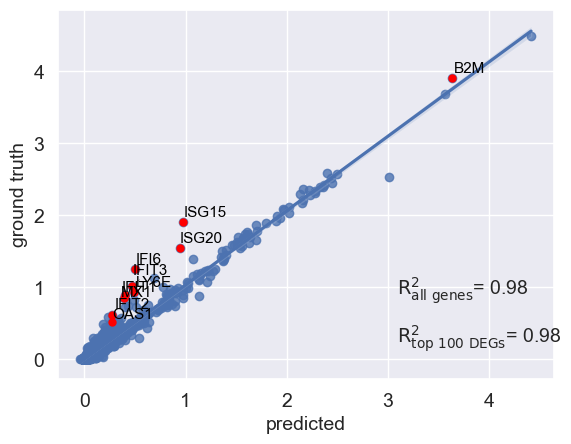

In [38]:
r2_value = model.plot_reg_mean_plot(
    eval_adata,
    condition_key="condition",
    axis_keys={"x": "predicted stimulated", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes=diff_genes,
    labels={"x": "predicted", "y": "ground truth"},
    show=True,
    legend=False,
)

We can additionally look at the distribution of the top upregulated genes by IFN-beta. For example, we plotted the distribution of expression in `ISG15`, a well-known gene induced after IFN stimulation. As observed, the model identified that this gene should be upregulated after stimulation with IFN-beta, and it indeed shifted values to a similar range in ground-truth (stimulated) cells.

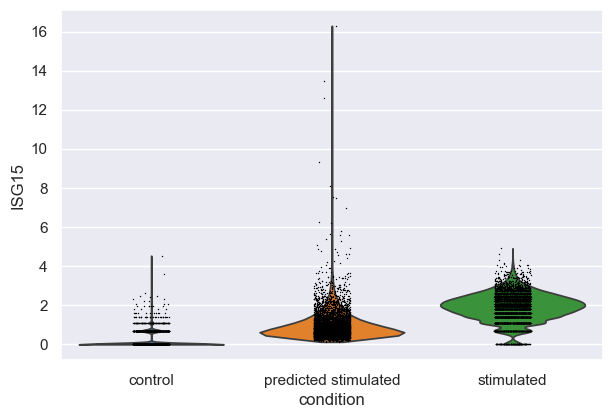

In [39]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

Overall, we demonstrated the application of scGen as an example of perturbation response models in predicting gene expression of the unseen population under desired perturbations. While perturbation response models provide in silico predictions, they cannot replace performing actual experiments. It is also unclear how much of the predicted response is attributed to cell type specific responses or across cell types. However, as observed in the case of scGen, it can predict the overall response for highly expressed genes yet provide poorer predictions for lowly expressed genes, which requires further optimization and motivation for developing more sophisticated and robust approaches.  

#### Summary

In this analysis, a VAE model to predict cell response to IFN-beta treatment using scGen. The model was training excluding CD4+ cells (unseen) cells, and then tested to preduct reponse of such cells. Contrasting the predicted response vs. the ground truth, and shows a high correlation. Note that perturbation response models provide in silico predictions and can guide experimental design. However, actual experimental validation is usually required un drug discovery pipelines. It is also unclear how much of the predicted response is attributed to cell type specific responses or across cell types. Heumos et al., 2023 discuss that scGen can predict the overall response for highly expressed genes yet provide poorer predictions for lowly expressed genes.

## Sources

1) [Best practices for single-cell analysis across modalities](https://www.sc-best-practices.org/conditions/perturbation_modeling.html) by [Heumos et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37002403/)
2) [GSEAPY: Gene Set Enrichment Analysis in Python](https://gseapy.readthedocs.io/en/latest/gseapy_tutorial.html)